### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
from IPython.display import Image
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an

## Must use Cycamore in jbae11 cycamore branch "standardized_verif"

`git clone https://github.com/jbae11/cycamore -b standardized_verif`

## ISSUES


In [3]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('cyclus.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [4]:
# plotting function
import matplotlib.pyplot as plt
def stacked_bar(dictionary, timestep, xlabel, ylabel,
                title, outputname, init_year, width):
    prev =np.zeros(1)
    top_index = True
    plot_list = []
    for key in dictionary:
        label = str(key)
        if sum(dictionary[key]) == 0:
            print(label + ' has no values')
        elif top_index is True:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           label=label)
            prev = dictionary[key]
            top_index = False
            plot_list.append(plot)
        else:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           bottom=prev,
                           label=label)
            prev =np.add(prev, dictionary[key])
            plot_list.append(plot)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    axes = plt.gca()
    axes.autoscale(tight=True)
    plt.grid(True)
    plt.legend()
    plt.savefig(outputname + '.png', format='png',
                bbox_inches='tight')
    plt.close()
    

def twosum(timeseries_list):
    """Aggregates timeseries list of length 2x to x
       by summing up the two adjacent values"""
    result = [0]
    list_indx = 0
    total = 0
    timeseries_list = timeseries_list[1:]
    while True:
        total += timeseries_list[list_indx]
        list_indx += 1
        if list_indx == len(timeseries_list) - 1:
            break
        if list_indx%12 == 0:
            result.append(total)
            total = 0
    return result

half_length = int((len(timestep)+1) / 12)
orion_half_length = int((len(timestep)+1) / 6)
orion_timestep = timestep[:orion_half_length] 
new_timestep = timestep[:half_length]


def read_from_data(data_path):
    """Reads from excel answer from Bo Feng from file"""
    file = open(data_path, 'r')
    timeseries = [0, 0]
    for row in file:
        value = float(row.replace('\n', ''))
        timeseries.append(value)
    return timeseries[:-4]

def push_back_one(timeseries):
    out = np.array(timeseries)
    out = np.append(out, timeseries[-1])
    return out[1:]

def pull_in_one(timeseries):
    out = np.array(timeseries)
    out = np.append(timeseries[0], out)
    return out[:-1]

def add_two(timeseries):
    result = []
    list_indx = 0
    total = 0
    while True:
        total += timeseries[list_indx]
        list_indx += 1
        if list_indx == len(timeseries) - 1:
            break
        if list_indx%2 == 0:
            result.append(total)
            total = 0
        return result

def average_two(timeseries):
    result = [0]
    list_indx = 0
    total = 0
    timeseries = timeseries[1:]
    while True:
        total += timeseries[list_indx]
        list_indx += 1
        if list_indx == len(timeseries) - 1:
            break
        if list_indx%2 == 0:
            result.append(total / 2)
            total = 0
    return result

half_half_length = int(half_length / 2)
new_new_timestep = timestep[:half_half_length]

### The output file should be named 
         
          month.sqlite

In [5]:
# get number of reactors and capacity timeseries
power_dict = an.get_power_dict(cur)
stacked_bar(power_dict, timestep, 'Year', 'Deployed Capacity [GWe]',
            'Deployed reactor capacities at the end of each year.',
            'power_plot', init_year, 1)
! mv power_plot.png ./results/power_plot.png

fac has no values


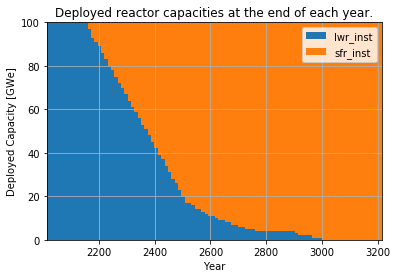

In [6]:
Image('./results/power_plot.png')

In [7]:
# get deployment scheme
dep_dict = {}

# lwr decommission
lwr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "lwr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in lwr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)

dep_dict['LWRs retired'] = dec_array

# sfr deployment
sfr_dep = cur.execute('SELECT entertime FROM agententry '
                      'where prototype = "sfr"').fetchall()
dep_array = np.zeros(duration)
entertime_list = []
for row in sfr_dep:
    entertime_list.append(row['entertime'])
for i in range(1, duration):
    dep_array[i-1] = entertime_list.count(i)

dep_dict['SFRs started up'] = dep_array


# read from data
data_lwr_decom = read_from_data('./bo/lwr_decom')
#data_lwr_decom = push_back_one(data_lwr_decom)
data_sfr_dep = read_from_data('./bo/sfr_deploy')
data_sfr_dep = push_back_one(data_sfr_dep)

plt.bar(init_year + new_timestep, twosum(dep_dict['LWRs retired']),
        label='LWRs retired [Cyclus]', width=0.8)
plt.plot(init_year + new_timestep, data_lwr_decom, label='LWRs retired [Feng et al.]')

plt.bar(init_year + new_timestep, twosum(dep_dict['SFRs started up']),
        label='SFRs started up [Cyclus]', alpha=0.4, width=0.8)
plt.plot(init_year + new_timestep, data_sfr_dep, label='SFRs started up [Feng et al.]')

plt.ylabel('Reactors')
plt.xlabel('Year')
plt.title('LWRs retired and SFRs started up each year')
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.legend()
plt.yticks(np.arange(0,15, 2))
plt.savefig('./results/dep.png', format='png',
            bbox_inches='tight')
plt.close()


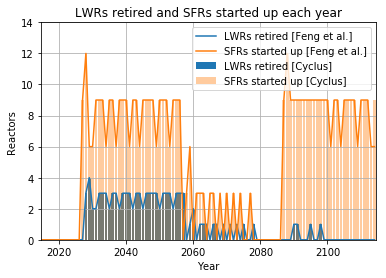

In [8]:
Image("./results/dep.png")

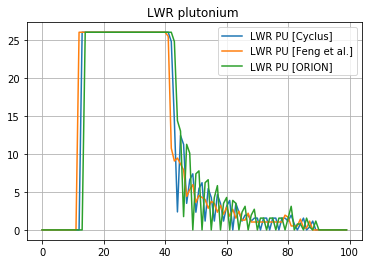

In [9]:
# sep lwr production


lwr_sep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
lwr_pu_prod = an.facility_commodity_flux(cur, lwr_sep_agentid, ['uox_pu'], True, False)


pu_output = cur.execute('SELECT time, value FROM separationevents '
                           'WHERE Type = "uox_pu" AND Agentid = ' + lwr_sep_agentid[0]).fetchall()
reprocessing_throughput = cur.execute('SELECT time, value FROM separationevents '
                                      'WHERE Type = "UNF" AND Agentid = ' + lwr_sep_agentid[0]).fetchall()
data_lwr_pu = read_from_data('./bo/lwr_sep_tru')
orion_lwr_pu = np.array(read_from_data('./orion/lwr_rep.csv')[13:]) * 0.013

uox_pu = an.get_timeseries(pu_output, duration, True)

uox_pu =twosum(uox_pu)
uox_pu = pull_in_one(uox_pu)

reprocessing_throughput = np.array(twosum(an.get_timeseries(reprocessing_throughput, duration, True))) * 0.013


plt.plot(new_timestep, uox_pu, label='LWR PU [Cyclus]')
plt.plot(new_timestep, data_lwr_pu, label = 'LWR PU [Feng et al.]')
plt.plot(new_timestep, orion_lwr_pu, label = 'LWR PU [ORION]')
plt.grid()
plt.title('LWR plutonium ')
plt.legend()
plt.show()

## Cycamore::Reactor only depletes half of its core when decommissioned. In this analysis, an edit to the source code is made so that all the core is depleted, like the other codes in the benchmark

No handles with labels found to put in legend.


0.04914630000013265


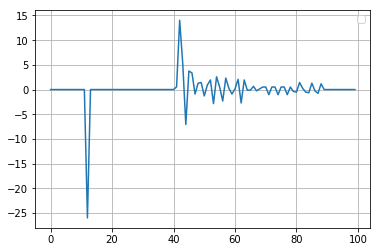

In [10]:
# find difference in previous plot
diff = uox_pu - np.array(data_lwr_pu)
print(sum(diff))
plt.plot(new_timestep, diff)
plt.grid()
plt.legend()
plt.show()

## This result is because the CYCAMORE::REACTOR, when decommissioned mid-cycle, only depletes half of its core. The remaining half is un-depleted (enriched UOX). Thus half of the discharged fuel from decommissioned reactors do not contain plutonium.

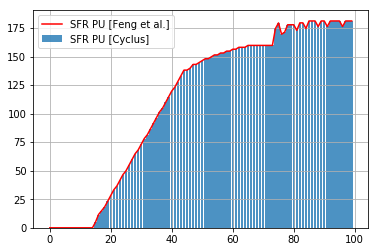

In [11]:
# sep sfr pu production
sfr_sep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_pu_prod = an.facility_commodity_flux(cur, sfr_sep_agentid, ['sfr_pu'], True, False)

sfr_pu = np.array(twosum(sfr_pu_prod['sfr_pu']))
data_sfr_pu = read_from_data('./bo/sfr_sep_tru')

plt.bar(new_timestep, sfr_pu, label='SFR PU [Cyclus]', alpha=0.8)
plt.plot(new_timestep, data_sfr_pu, label='SFR PU [Feng et al.]', color='r' )
plt.grid()
plt.legend()
plt.show()

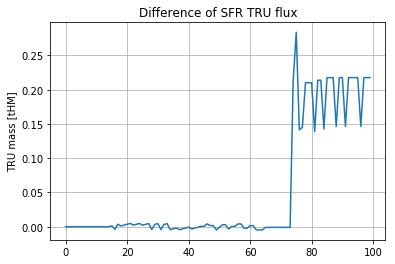

5.180039999999957


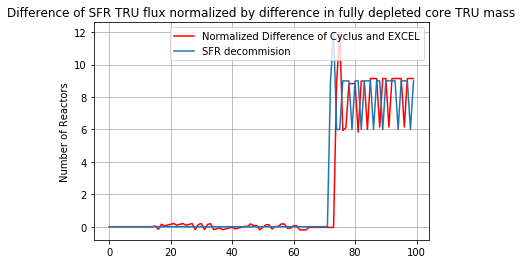

In [12]:
diff = np.array(sfr_pu) - np.array(data_sfr_pu)
norm_diff = diff / 0.0238
plt.plot(new_timestep, diff)
plt.title('Difference of SFR TRU flux')
plt.ylabel('TRU mass [tHM]')
plt.grid()
plt.show()
plt.close()


print(sum(diff))
sfr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "sfr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in sfr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)
dep_dict['LWRs retired'] = dec_array

plt.plot(new_timestep, norm_diff, label='Normalized Difference of Cyclus and EXCEL', color='r')
plt.plot(new_timestep, twosum(dep_dict['LWRs retired']), label='SFR decommision')
plt.legend()
plt.title('Difference of SFR TRU flux normalized by difference in fully depleted core TRU mass')
plt.ylabel('Number of Reactors')
plt.grid()
plt.show()
plt.close()



## The Difference in mass TRU flux laggs the SFR decommission by one timestep because the decomssion stage is the very last step of Cyclus time execution, and the next material exchange occurs the next timestep.

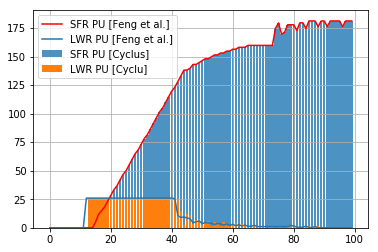

In [13]:
plt.bar(new_timestep, sfr_pu, label='SFR PU [Cyclus]', alpha=0.8)
plt.plot(new_timestep, data_sfr_pu, label='SFR PU [Feng et al.]', color='r' )
plt.bar(new_timestep, uox_pu, label='LWR PU [Cyclu]')
plt.plot(new_timestep, data_lwr_pu, label = 'LWR PU [Feng et al.]')
plt.grid()
plt.legend()
plt.show()

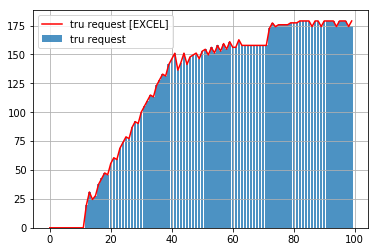

In [14]:
mixer_agentid = an.get_prototype_id(cur, 'sfr_mixer_sfr')
tru_request = an.facility_commodity_flux(cur, mixer_agentid, ['sfr_fuel'], True, False)
tru_request = np.array(tru_request['sfr_fuel']) * 0.1387
tru_request = twosum(tru_request)
tru_request.append(tru_request[-1])
tru_request = tru_request[1:]


# data tru request
data_tru_request = read_from_data('./bo/tru_request')

plt.bar(new_timestep, tru_request, label='tru request', alpha=0.8)
plt.plot(new_timestep, data_tru_request, label='tru request [EXCEL]', color='r')

plt.grid()
plt.legend()
plt.show()
plt.close()


7.492009999999226


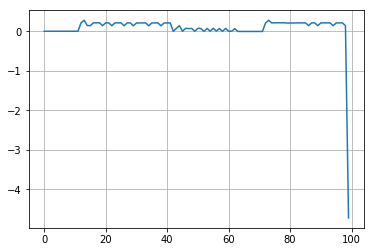

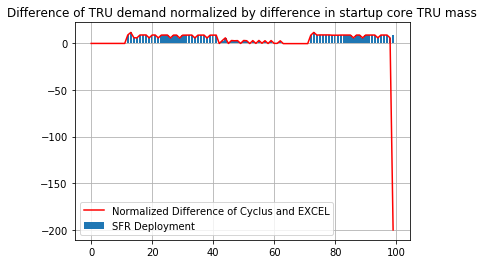

In [15]:
diff = np.array(tru_request) - np.array(data_tru_request)
norm_diff = diff / 0.023579
print(sum(diff))
plt.plot(new_timestep, diff)
plt.grid()
plt.show()
plt.close()

plt.plot(new_timestep, norm_diff, label= 'Normalized Difference of Cyclus and EXCEL', color='r')
plt.bar(new_timestep, twosum(dep_dict['SFRs started up']), label='SFR Deployment')
plt.title('Difference of TRU demand normalized by difference in startup core TRU mass')
plt.legend()
plt.grid()
plt.show()
plt.close()




## Notice that the normalized difference matches the SFR deployment, which means that the error is due to the difference in SFR core size.

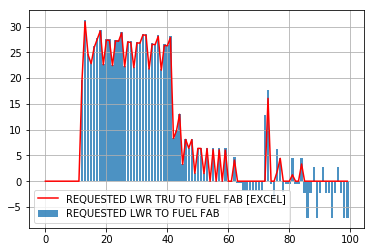

In [16]:
# requested LWR TRU to fuel fab
requested_lwr_tru = np.array(tru_request) - sfr_pu
data_lwr_tru = read_from_data('./bo/requested_lwr_tru')


plt.bar(new_timestep, requested_lwr_tru , label = 'REQUESTED LWR TO FUEL FAB', alpha=0.8)
plt.plot(new_timestep, data_lwr_tru , label = 'REQUESTED LWR TRU TO FUEL FAB [EXCEL]', color='r')
plt.grid()
plt.legend()
plt.show()
plt.close()

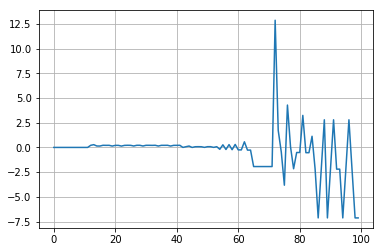

In [17]:
# find the difference of previous plot

diff = requested_lwr_tru - np.array(data_lwr_tru)
plt.plot(new_timestep, diff)
plt.grid()
plt.show()
plt.close()

## The difference is caused by the core mass
## the paper has 3.95 tHM batch with 3.96 batches = 15.63 tHM per core
## Cyclus, with its discrete batch has 3.95 tHM batch with 4 batches = 15.8 tH per core
## Thus Cyclus requires 0.17 tHM more fuel at startup. 
## that is 0.023579 tHM more TRU to start up
## and 0.0238 tHM more when the core discharge at decommission is reprocessed

## This plot is produced by following the steps in the EXCEL sheet where the surplus separated LWR TRU is given by the cumulative value of (separated LWR TRU) - (requested LWR TRU to fuel fab). Since the requested LWR TRUs are more because the LWR core size is bigger, and the requested LWR TRU to fuel fab is 

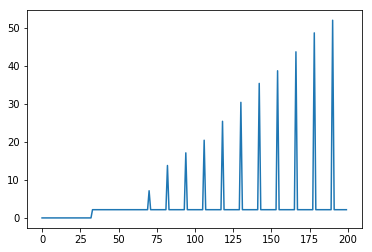

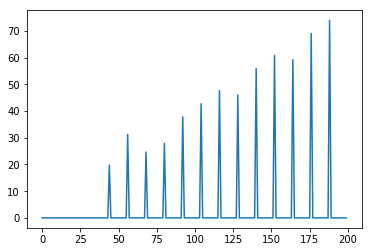

In [18]:
# unsed TRU recovered from UNF

# separated pu timeseries
pu_influx = cur.execute('SELECT time, Value FROM separationevents '
                        'WHERE type = "uox_pu" OR type = "sfr_pu"').fetchall()
pu_inv_timeseries = an.get_timeseries(pu_influx, duration, True)

influx1 = cur.execute('SELECT time, Value FROM separationevents '
                      'WHERE type = "uox_pu"').fetchall()
influx2 = cur.execute('SELECT time, Value FROM separationevents '
                      'WHERE type = "sfr_pu"').fetchall()
pu_inv_timeseries = np.array(an.get_timeseries(influx1, duration, True)) + np.array(an.get_timeseries(influx2, duration, True))

cum1 = np.cumsum(pu_inv_timeseries)

plt.plot(pu_inv_timeseries[100:300])
plt.show()
plt.close()

# pu usage
sfr_agentid = an.get_prototype_id(cur, 'sfr_mixer_sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid, ['sfr_fuel'], True, False)
pu_used = np.array(sfr_load['sfr_fuel']) * 0.1387

pu_used = np.append(np.array(pu_used), pu_used[-1])
pu_used = pu_used[1:]

plt.plot(pu_used[100:300])
plt.show()
plt.close()

leftover = np.cumsum(pu_inv_timeseries - pu_used)
    
leftover = np.zeros(len(pu_used))
for indx, val in enumerate(leftover):
    if indx == 0:
        continue
    leftover[indx] = leftover[indx-1] + pu_inv_timeseries[indx] - pu_used[indx]

# get from data
data_surplus_tru = read_from_data('./bo/surplus_tru')
orion_surplus_tru = read_from_data('./orion/sep_tru.csv')[27:]

plt.plot(init_year + orion_timestep * 6 , orion_surplus_tru, label='SURPLUS SEP TRU [ORION]')
plt.plot(init_year + timestep, leftover, label='SURPLUS SEP LWR TRU')
#plt.plot(timestep, data_surplus_tru + [data_surplus_tru[-1]], label='SURPLUS SEP LWR TRU [EXCEL]')
plt.xlabel('Year')
plt.ylabel('Unused TRU from UNF [tHM]')
plt.legend()
plt.title('Inventory of unused TRU recovered from UNF')
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/tru.png', format='png',
            bbox_inches='tight')
plt.close()

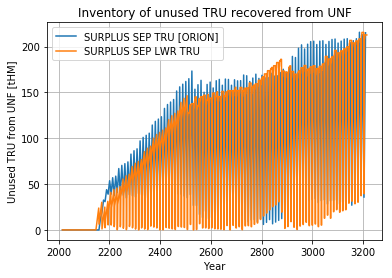

In [19]:
Image('./results/tru.png')

In [20]:
def find_min(group_by, timeseries):
    result = []
    for i in range(0, int(np.floor(len(timeseries) / group_by))):
        group = timeseries[i * group_by : i * group_by + group_by -1]
        add = np.min(group)
        result.append(add)
    return np.array(result)
#plt.plot(init_year + new_timestep, find_min(2, orion_surplus_tru), label='ORION')
plt.plot(init_year + new_timestep, find_min(12, leftover), label='CYCLUS')
plt.plot(init_year + new_timestep, data_surplus_tru + [data_surplus_tru[-1]], label='Feng et al.', linestyle = '-.')
plt.xlabel('Year')
plt.ylabel('Unused TRU from UNF [tHM]')
plt.title('Inventory of unused TRU recovered from UNF')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/tru.png', format='png',
            bbox_inches='tight')
plt.close()

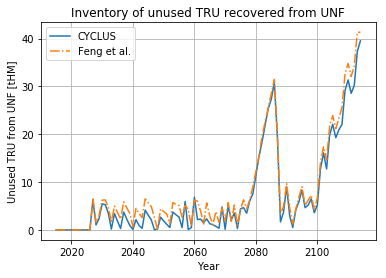

In [21]:
Image('./results/tru.png')

## differences due to changes in SFR startup core size and averaging

In [22]:
# Annual Fresh Fuel Loading Rates

# lwr fuel loading 
lwr_agentid = an.get_prototype_id(cur, 'lwr')
lwr_load = an.facility_commodity_flux(cur, lwr_agentid,
                                      ['uox'], False, False)
## have to make the first datapoint equal to the second datapoint (BC)
## the first datapoint lwr_load['uox'][1] 
## is the initial loading of all lwrs
lwr_load['uox'][1] = lwr_load['uox'][2]
lwr_load['uox'][0] = lwr_load['uox'][1]
# aggregate
new_lwr_load =  twosum(lwr_load['uox'])
new_lwr_load[1] = new_lwr_load[2]
# sfr fuel loading
sfr_agentid = an.get_prototype_id(cur, 'sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid,
                                      ['sfr_fuel'],
                                      False, False)
# aggregate
new_sfr_load = twosum(sfr_load['sfr_fuel'])

## Get from data
data_lwr_load = read_from_data('./bo/lwr_fuel_loaded')
data_sfr_load = read_from_data('./bo/sfr_fuel_loaded')
orion_lwr_load = read_from_data('./orion/lwr_fuel_demand.csv')[13:]
orion_sfr_load = read_from_data('./orion/sfr_fuel_demand.csv')[13:]


plt.plot(new_timestep + init_year , new_lwr_load,
         label='LWR Fresh Fuel [Cyclus]', alpha = 0.7)
plt.plot(new_timestep + init_year , data_lwr_load,
         label='LWR Fresh Fuel [Feng et al.]', linestyle = '-.')
#plt.plot(new_timestep + init_year , orion_lwr_load,
#         label='LWR Fresh Fuel [ORION]', linestyle = '-.')


plt.plot(new_timestep + init_year, new_sfr_load,
         label='SFR Fresh Fuel [Cyclus]', alpha=0.7)
plt.plot(new_timestep + init_year, data_sfr_load,
         label='SFR Fresh Fuel [Feng et al.]', linestyle = '-.')
#plt.plot(new_timestep + init_year , orion_sfr_load,
#         label='LWR Fresh Fuel [ORION]', linestyle = '-.')


plt.xlabel('Year')
plt.ylabel('Fresh Fuel Loading [MTHM]')
plt.title('Fresh Fuel Loading')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/fuel_load.png', format='png',
            bbox_inches='tight')
plt.close()

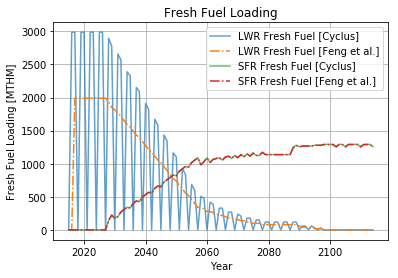

In [23]:
Image("./results/fuel_load.png")

In [24]:
# difference in previous plot
diff_lwr_load = np.array(new_lwr_load) - np.array(data_lwr_load)
diff_sfr_load = np.array(new_sfr_load) - np.array(data_sfr_load)

plt.plot(new_timestep + init_year , diff_lwr_load,
         label='LWR FUEL LOAD DIFF' )
plt.plot(new_timestep + init_year, diff_sfr_load,
         label='SFR FUEL LOAD DIFF')
plt.xlabel('Year')
plt.ylabel('Fuel loading difference [tHM]')
plt.title('Fuel loading difference (Cyclus - Excel)')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/fuel_load_diff.png', format='png',
            bbox_inches='tight')
plt.close()


norm_diff_sfr_load = diff_sfr_load / 0.17
plt.plot(new_timestep + init_year, norm_diff_sfr_load,
         label='Normalized SFR fuel load diff', color = 'r')

plt.bar(new_timestep + init_year, pull_in_one(twosum(dep_dict['SFRs started up'])), label='SFR Deployment')
plt.xlabel('Year')
plt.ylabel('Normalized fuel loading difference')
plt.legend()
plt.title('Fuel loading difference normalized by SFR core mass difference')
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/fuel_load_diff_norm.png', format='png',
            bbox_inches='tight')
plt.close()

In [25]:
# Inventory of discharged and cooled UNF waiting for reprocessing

query_result = cur.execute('SELECT quantity FROM storageinventory '
                           'WHERE prototype = "uox_unf_storage" '
                           'AND status = "Cooling"').fetchall()
uox_storage_timeseries = [0]
for row in query_result:
    uox_storage_timeseries.append(row[0] / 1000.0)

sfr_query = cur.execute('SELECT quantity FROM storageinventory '
                        'WHERE prototype = "sfr_unf_storage" '
                        'AND status = "Cooling"').fetchall()
sfr_storage_timeseries = [0]
for row in sfr_query:
    sfr_storage_timeseries.append(row[0] / 1000.0)

# average of two timesteps


#new_uox_storage = np.array(twosum(uox_storage_timeseries[:-1])) / 12
#new_sfr_storage = np.array(twosum(sfr_storage_timeseries[:-1])) / 12

#new_uox_storage = push_back_one(new_uox_storage)

## get from data
data_uox_storage = read_from_data('./bo/lwr_cool')
data_sfr_storage = read_from_data('./bo/sfr_cool')

orion_uox_storage = read_from_data('./orion/lwr_cooling.csv')[27:]
orion_sfr_storage = read_from_data('./orion/sfr_cooling.csv')[27:]

plt.plot(init_year + timestep/12 , uox_storage_timeseries,
             label='LWR UNF [Cyclus]')
plt.plot(new_timestep + init_year , data_uox_storage,
             label='LWR UNF [Feng et al.]',linestyle = '-.')
#plt.plot(orion_timestep / 2 + init_year, orion_uox_storage,
#         label='LWR UNF [ORION]')

plt.plot(init_year + timestep/12, sfr_storage_timeseries,
         label='SFR UNF [Cyclus]')
plt.plot(new_timestep + init_year, data_sfr_storage,
         label='SFR UNF [Feng et al.]',linestyle = '-.')
#plt.plot(orion_timestep /2 + init_year, orion_sfr_storage,
#         label='SFR UNF [ORION]')

plt.xlabel('Year')
plt.ylabel('Used Fuel in Cooling Storage [t]')
plt.title('Inventory of discharged UNF in mandatory cooling storage')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/fuel_discharge.png', format='png',
            bbox_inches='tight')
plt.close()

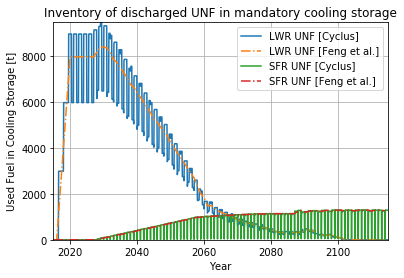

In [26]:
Image('./results/fuel_discharge.png')

In [27]:

plt.plot(orion_timestep / 2 + init_year, orion_uox_storage,
         label='LWR UNF [ORION]')
plt.plot(init_year + timestep/12, uox_storage_timeseries, label='LWR UNF')
plt.plot(new_timestep + init_year , data_uox_storage,
             label='LWR UNF [EXCEL]', linestyle='-.')

plt.plot(init_year + timestep/12, sfr_storage_timeseries, label='LWR UNF')
plt.plot(orion_timestep /2 + init_year, orion_sfr_storage,
         label='SFR UNF [ORION]')
plt.plot(new_timestep + init_year, data_sfr_storage,
         label='SFR UNF [EXCEL]', linestyle='-.')

plt.xlabel('Year')
plt.ylabel('Used Fuel in Cooling Storage [t]')
plt.title('Inventory of discharged UNF in mandatory cooling storage')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/fuel_discharge_monthly.png', format='png',
            bbox_inches='tight')
plt.close()

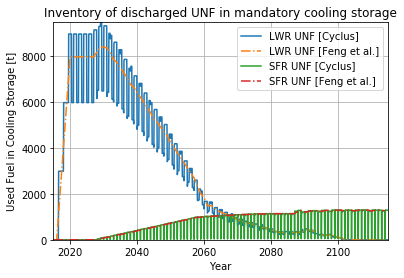

In [28]:
Image('./results/fuel_discharge.png')

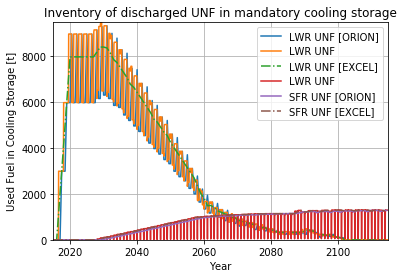

In [29]:
Image('./results/fuel_discharge_monthly.png')

In [30]:
"""
#difference in previous plot
diff_lwr_load = np.array(new_uox_storage) - np.array(data_uox_storage)
diff_sfr_load = np.array(new_sfr_storage) - np.array(data_sfr_storage)
plt.plot(new_timestep + init_year , diff_lwr_load,
         label='LWR UNF STORAGE DIFF' )
#plt.scatter(new_timestep + init_year, diff_sfr_load,
#         label='SFR UNF STORAGE DIFF')
plt.legend()
plt.show()
plt.close()
"""

"\n#difference in previous plot\ndiff_lwr_load = np.array(new_uox_storage) - np.array(data_uox_storage)\ndiff_sfr_load = np.array(new_sfr_storage) - np.array(data_sfr_storage)\nplt.plot(new_timestep + init_year , diff_lwr_load,\n         label='LWR UNF STORAGE DIFF' )\n#plt.scatter(new_timestep + init_year, diff_sfr_load,\n#         label='SFR UNF STORAGE DIFF')\nplt.legend()\nplt.show()\nplt.close()\n"

In [31]:
# Cooled storage = To cooled storage - fuel reprocessed
to_cooled_storage = cur.execute('SELECT time,quantity FROM storageinventory '
                                'WHERE prototype = "uox_unf_storage" '
                                'AND status = "Now Cooled"').fetchall()
to_cooled_storage = an.get_timeseries(to_cooled_storage, duration, True)
to_cooled_storage_month = to_cooled_storage
to_cooled_storage = twosum(to_cooled_storage)

data_to_cooled_storage = read_from_data('./bo/lwr_to_cooled')


to_cooled_storage_sfr = cur.execute('SELECT time,quantity FROM storageinventory '
                                    'WHERE prototype = "sfr_unf_storage" '
                                    'AND status = "Now Cooled"').fetchall()
to_cooled_storage_sfr = an.get_timeseries(to_cooled_storage_sfr, duration, True)
to_cooled_storage_sfr =twosum(to_cooled_storage_sfr)


# Fuel Reprocessed
agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT time,value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()
uox_rep = an.get_timeseries(uox_rep, duration, True)
uox_rep = pull_in_one(uox_rep)
uox_rep_month = uox_rep
uox_rep = twosum(uox_rep)


data_uox_rep = read_from_data('./bo/lwr_rep')

agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_rep = cur.execute('SELECT time,value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()
sfr_rep = an.get_timeseries(sfr_rep, duration, True)
sfr_rep = twosum(sfr_rep)
sfr_fuel_sent = an.facility_commodity_flux(cur, agentid, ['cooled_sfr_unf'], False, False)
sfr_waiting = np.array(to_cooled_storage_sfr) - np.array(twosum(sfr_fuel_sent['cooled_sfr_unf']))



# the cumulative difference is the cooled inventory waiting for reprocessing
cooled_inv = np.zeros(len(data_uox_rep))
for indx, val in enumerate(cooled_inv):
    if indx == 0:
        continue
    cooled_inv[indx] = cooled_inv[indx-1] + to_cooled_storage[indx] - uox_rep[indx]

data_cooled_inv = read_from_data('./bo/lwr_cooled')
data_cooled_inv_sfr = read_from_data('./bo/sfr_cooled')
    
orion_cooled_inv = read_from_data('./orion/lwr_waiting.csv')[27:]
#plt.plot(init_year + orion_timestep/2, orion_cooled_inv, label='LWR UNF [ORION]')
plt.plot(new_timestep + init_year, to_cooled_storage , label='LWR UNF')
#plt.plot(new_timestep + init_year, data_cooled_inv, label='LWR UNF [EXCEL]', linestyle='-.')
#plt.plot(new_timestep + init_year, sfr_waiting, label='SFR UNF')
#plt.plot(new_timestep + init_year, data_cooled_inv_sfr, label='SFR UNF [EXCEL]', linestyle='-.')

plt.xlabel('Year')
plt.ylabel('UNF waiting for Reprocessing [MTHM]')
plt.title('Inventory of cooled UNF waiting for reprocessing')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/waiting.png', format='png',
            bbox_inches='tight')
plt.close()

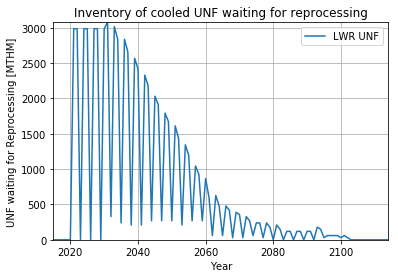

In [32]:
Image('./results/waiting.png')

In [37]:
# Cooled storage = To cooled storage - fuel reprocessed
to_cooled_storage = cur.execute('SELECT time,quantity FROM storageinventory '
                                'WHERE prototype = "uox_unf_storage" '
                                'AND status = "Now Cooled"').fetchall()
to_cooled_storage = an.get_timeseries(to_cooled_storage, duration, True)
to_cooled_storage_month = to_cooled_storage
to_cooled_storage = twosum(to_cooled_storage)

data_to_cooled_storage = read_from_data('./bo/lwr_to_cooled')


to_cooled_storage_sfr = cur.execute('SELECT time,quantity FROM storageinventory '
                                    'WHERE prototype = "sfr_unf_storage" '
                                    'AND status = "Now Cooled"').fetchall()
to_cooled_storage_sfr = an.get_timeseries(to_cooled_storage_sfr, duration, True)
to_cooled_storage_sfr =twosum(to_cooled_storage_sfr)


# Fuel Reprocessed
agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT time,value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()
uox_rep = an.get_timeseries(uox_rep, duration, True)
uox_rep = pull_in_one(uox_rep)
uox_rep_month = uox_rep
uox_rep = twosum(uox_rep)


data_uox_rep = read_from_data('./bo/lwr_rep')

agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_rep = cur.execute('SELECT time,value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()
sfr_rep = an.get_timeseries(sfr_rep, duration, True)
sfr_rep = twosum(sfr_rep)
sfr_fuel_sent = an.facility_commodity_flux(cur, agentid, ['cooled_sfr_unf'], False, False)
sfr_waiting = np.array(to_cooled_storage_sfr) - np.array(twosum(sfr_fuel_sent['cooled_sfr_unf']))



# the cumulative difference is the cooled inventory waiting for reprocessing
cooled_inv = np.zeros(len(to_cooled_storage_month))
for indx, val in enumerate(cooled_inv):
    if indx == 0:
        continue
    cooled_inv[indx] = cooled_inv[indx-1] + to_cooled_storage_month[indx] - uox_rep_month[indx]

data_cooled_inv = read_from_data('./bo/lwr_cooled')
data_cooled_inv_sfr = read_from_data('./bo/sfr_cooled')
    

plt.plot(timestep / 12 + init_year, cooled_inv, label='LWR UNF [Cyclus]')
plt.plot(new_timestep + init_year, data_cooled_inv, label='LWR UNF [Feng et al.]', linestyle='-.')
plt.plot(new_timestep + init_year, sfr_waiting, label='SFR UNF [Cyclus]')
plt.plot(new_timestep + init_year, data_cooled_inv_sfr, label='SFR UNF [Feng et al.]', linestyle='-.')

plt.xlabel('Year')
plt.ylabel('UNF waiting for Reprocessing [MTHM]')
plt.title('Inventory of discharge and cooled UNF waiting for reprocessing')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/waiting.png', format='png',
            bbox_inches='tight')
plt.close()

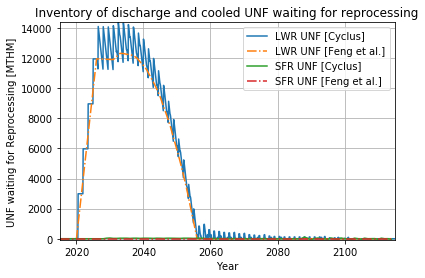

In [38]:
Image('./results/waiting.png')

In [35]:
# annual reprocessing throughput
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT Time, Value from separationevents '
                      'WHERE Type = "UNF" AND Agentid = ' + uox_rep_agentid[0]).fetchall()
uox_rep = twosum(an.get_timeseries(uox_rep, duration, True))
uox_rep = pull_in_one(uox_rep)

sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_rep = cur.execute('SELECT Time, Value from separationevents '
                      'WHERE Type = "UNF" AND Agentid = ' + sfr_rep_agentid[0]).fetchall()
sfr_rep = twosum(an.get_timeseries(sfr_rep, duration, True))

# get from data
data_uox_rep = read_from_data('./bo/lwr_rep')
data_sfr_rep = read_from_data('./bo/sfr_rep')

orion_uox_rep = read_from_data('./orion/lwr_rep.csv')[13:]
orion_sfr_rep = read_from_data('./orion/sfr_rep.csv')[13:]
print(len(orion_uox_rep))

#plt.plot(new_timestep + init_year, orion_uox_rep, label='LWR UNF [ORION]')
plt.plot(new_timestep + init_year, uox_rep, label='LWR UNF [Cyclus]')
plt.plot(new_timestep + init_year, data_uox_rep, label='LWR UNF [Feng et al.]', linestyle='-.')

#plt.plot(new_timestep + init_year ,orion_sfr_rep, label='SFR UNF [ORION]')
plt.plot(new_timestep + init_year, sfr_rep, label='SFR UNF [Cyclus]')
plt.plot(new_timestep + init_year, data_sfr_rep, label='SFR UNF [Feng et al.]', linestyle='-.')

plt.xlabel('Year')
plt.ylabel('Annual Reprocessing Rate [t/y]')
plt.title('Annual reprocessing throughputs')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/rep.png', format='png',
            bbox_inches='tight')
plt.close()


100


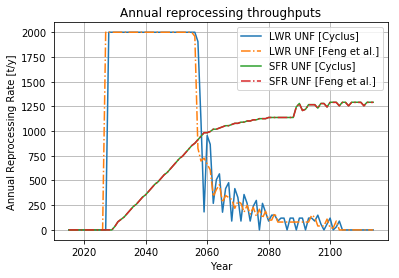

In [36]:
Image('./results/rep.png')